# DA5401 – Assignment 5
**Name:** Anan Madhav T V  
**Roll No:** MM22B013

---

### Notebook outline
- Part A: Preprocessing and Initial Setup
- Part B: T-SNE and Veracity Inspection
- Part C: Isomap and Manifold Learning

## Part A — Preprocessing and Initial Setup

### Data loading

In [2]:
import numpy as np
import pandas as pd
from scipy.io import arff
from collections import Counter
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from scipy.stats import zscore
from sklearn.manifold import Isomap
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET


In [3]:
data, meta = arff.loadarff('yeast.arff')
df = pd.DataFrame(data)

df = df.applymap(lambda x: x.decode('utf-8') if isinstance(x, bytes) else x)
print('Loaded ARFF: rows =', df.shape[0], ', columns =', df.shape[1])

Loaded ARFF: rows = 2417 , columns = 117


C:\Users\ANAN MADHAV\AppData\Local\Temp\ipykernel_8360\2848314526.py:4: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: x.decode('utf-8') if isinstance(x, bytes) else x)


In [4]:
tree = ET.parse('yeast.xml')
root = tree.getroot()
labels = root.findall('.//{http://mulan.sourceforge.net/labels}label')
label_names = [lbl.attrib['name'] for lbl in labels]
print('Label names found in XML (count):', len(label_names))
print(label_names)

Label names found in XML (count): 14
['Class1', 'Class2', 'Class3', 'Class6', 'Class4', 'Class10', 'Class11', 'Class5', 'Class7', 'Class8', 'Class9', 'Class12', 'Class13', 'Class14']


In [5]:
n_labels = 14
X_df = df.iloc[:, :-n_labels].astype(float)
Y_df = df.iloc[:, -n_labels:].astype(int)

Y_df.columns = label_names
print('X shape:', X_df.shape)
X_df.head()

X shape: (2417, 103)


,Att1,Att2,Att3,Att4,Att5,Att6,Att7,Att8,Att9,Att10,...,Att94,Att95,Att96,Att97,Att98,Att99,Att100,Att101,Att102,Att103
0,0.004168,-0.170975,-0.156748,-0.142151,0.058781,0.026851,0.197719,0.041850,0.066938,-0.056617,...,0.006166,-0.012976,-0.014259,-0.015024,-0.010747,0.000411,-0.032056,-0.018312,0.030126,0.124722
1,-0.103956,0.011879,-0.098986,-0.054501,-0.007970,0.049113,-0.030580,-0.077933,-0.080529,-0.016267,...,0.007680,0.027719,-0.085811,0.111123,0.050541,0.027565,-0.063569,-0.041471,-0.079758,0.017161
2,0.509949,0.401709,0.293799,0.087714,0.011686,-0.006411,-0.006255,0.013646,-0.040666,-0.024447,...,0.096277,-0.044932,-0.089470,-0.009162,-0.012010,0.308378,-0.028053,0.026710,-0.066565,-0.122352
3,0.119092,0.004412,-0.002262,0.072254,0.044512,-0.051467,0.074686,-0.007670,0.079438,0.062184,...,-0.083809,0.200354,-0.075716,0.196605,0.152758,-0.028484,-0.074207,-0.089227,-0.049913,-0.043893
4,0.042037,0.007054,-0.069483,0.081015,-0.048207,0.089446,-0.004947,0.064456,-0.133387,0.068878,...,-0.060467,0.044351,-0.057209,0.028047,0.029661,-0.050026,0.023248,-0.061539,-0.035160,0.067834


In [6]:
print('Y shape:', Y_df.shape)
Y_df.head()

Y shape: (2417, 14)


,Class1,Class2,Class3,Class6,Class4,Class10,Class11,Class5,Class7,Class8,Class9,Class12,Class13,Class14
0,0,0,0,0,0,0,1,1,0,0,0,1,1,0
1,0,0,1,1,0,0,0,0,0,0,0,0,0,0
2,0,1,1,0,0,0,0,0,0,0,0,1,1,0
3,0,0,1,1,0,0,0,0,0,0,0,0,0,0
4,0,0,1,1,1,1,0,0,0,0,0,0,0,0


### Dimensionality check

In [7]:
n_instances = X_df.shape[0]
n_features = X_df.shape[1]
n_labels = Y_df.shape[1]
print('Number of instances (data points):', n_instances)
print('Number of features:', n_features)
print('Number of labels:', n_labels)

Number of instances (data points): 2417
Number of features: 103
Number of labels: 14


### Label selection for visualization

Create a categorical index for plotting with: two most frequent single-label classes, the most frequent multi-label combination, and 'Other'.

In [8]:
#single-label classes
single_mask = (Y_df.sum(axis=1) == 1)
single_counts = Y_df[single_mask].sum(axis=0).sort_values(ascending=False)
top2_single = single_counts.index[:2].tolist()
print("Top-2 single labels (from pure single-label rows):", top2_single)
print("Counts among pure single-label rows:\n", single_counts.head(6))


Top-2 single labels (from pure single-label rows): ['Class1', 'Class2']
Counts among pure single-label rows:
 Class1     32
Class2      0
Class3      0
Class6      0
Class4      0
Class10     0
dtype: int64


In [9]:
#most frequent multi-label combination
multi_mask = (Y_df.sum(axis=1) > 1)
if multi_mask.sum() > 0:
    multi_keys = Y_df[multi_mask].apply(lambda r: tuple(r.values.tolist()), axis=1)
    multi_counts = multi_keys.value_counts()
    most_freq_multi = multi_counts.index[0]
    print("Most frequent multi-label combination (as a 14-tuple):")
    print(most_freq_multi)
    print("Its count:", multi_counts.iloc[0])


Most frequent multi-label combination (as a 14-tuple):
(0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0)
Its count: 237


In [10]:
def make_color_index(row):
    active = [lbl for lbl,val in row.items() if val==1]
    
    if len(active)==1 and active[0] in top2_single:
        return 0 if active[0]==top2_single[0] else 1

    if most_freq_multi is not None and tuple(row.values.tolist()) == most_freq_multi:
        return 2

    return 3

color_codes = Y_df.apply(make_color_index, axis=1).astype(int)


In [11]:
cnt = Counter(color_codes.tolist())
mapping = {
    0: f"TopSingle_1: {top2_single[0] if len(top2_single)>0 else 'N/A'}",
    1: f"TopSingle_2: {top2_single[1] if len(top2_single)>1 else 'N/A'}",
    2: "MostFreqMulti",
    3: "Other"
}
print("Category counts:")
for k in range(4):
    print(k, mapping[k], "->", cnt.get(k,0))

color_labels = [mapping[c] for c in color_codes]


Category counts:
0 TopSingle_1: Class1 -> 32
1 TopSingle_2: Class2 -> 0
2 MostFreqMulti -> 237
3 Other -> 2148


### Scaling

Scaling is essential for distance-based algorithms because they are highly sensitive to the numerical range of features. Without it, features with larger values will disproportionately influence distance calculations, creating a bias where the algorithm incorrectly assumes these features are more important simply due to their scale. By transforming all features to a common range, scaling ensures each contributes equally to the analysis. This allows the model to identify the true underlying patterns in the data, free from distortions caused by arbitrary units of measurement.

In [12]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_df)
print('X_scaled shape:', X_scaled.shape)

X_scaled_df = pd.DataFrame(X_scaled, columns=X_df.columns)
X_scaled_df.head()

X_scaled shape: (2417, 103)


,Att1,Att2,Att3,Att4,Att5,Att6,Att7,Att8,Att9,Att10,...,Att94,Att95,Att96,Att97,Att98,Att99,Att100,Att101,Att102,Att103
0,0.030752,-1.742591,-1.601326,-1.468980,0.594010,0.271117,2.023802,0.428070,0.683885,-0.584890,...,0.074380,-0.139039,-0.142884,-0.162409,-0.115009,0.020075,-0.320076,-0.178076,0.320417,1.178867
1,-1.079454,0.125835,-1.010264,-0.564893,-0.094933,0.499948,-0.326167,-0.809579,-0.847347,-0.167984,...,0.090608,0.281957,-0.886751,1.143263,0.521680,0.307877,-0.645355,-0.423947,-0.859425,0.096189
2,5.224059,4.109170,3.008988,0.902018,0.107939,-0.070783,-0.075781,0.136654,-0.433427,-0.252502,...,1.040237,-0.469629,-0.924791,-0.101735,-0.128129,3.284185,-0.278757,0.299908,-0.717769,-1.308110
3,1.210780,0.049537,-0.020516,0.742552,0.446738,-0.533913,0.757376,-0.083592,0.813679,0.642590,...,-0.890019,2.067892,-0.781802,2.028035,1.583559,-0.286180,-0.755161,-0.930956,-0.538974,-0.518363
4,0.419587,0.076533,-0.708369,0.832919,-0.510222,0.914530,-0.062317,0.661644,-1.396200,0.711754,...,-0.639827,0.454017,-0.589400,0.283393,0.304769,-0.514501,0.250775,-0.637002,-0.380569,0.606249


## Part B — t-SNE and Veracity Inspection


### t-SNE Implementation

In [13]:
perps = [5, 10, 20, 30, 40, 50]
tsne_results = {}
for p in perps:
    tsne = TSNE(n_components=2, perplexity=p, random_state=42, init='pca', learning_rate='auto')
    tsne_results[p] = tsne.fit_transform(X_scaled)
    print('Computed t-SNE for perplexity', p)

Computed t-SNE for perplexity 5
Computed t-SNE for perplexity 10
Computed t-SNE for perplexity 20
Computed t-SNE for perplexity 30
Computed t-SNE for perplexity 40
Computed t-SNE for perplexity 50


### Visualization

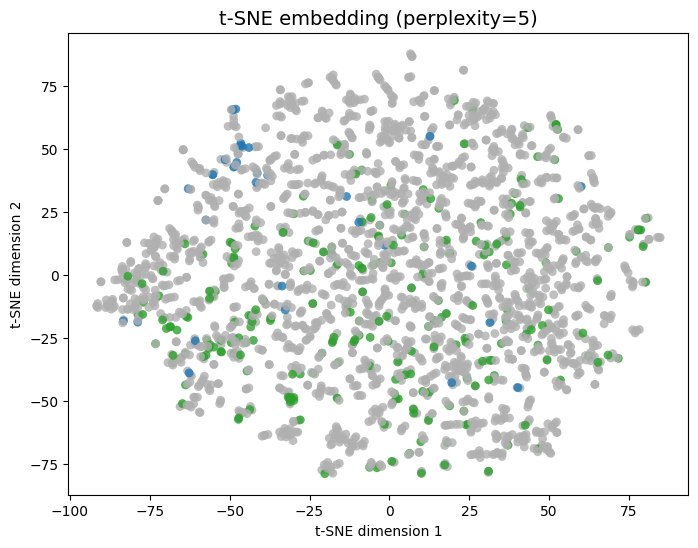

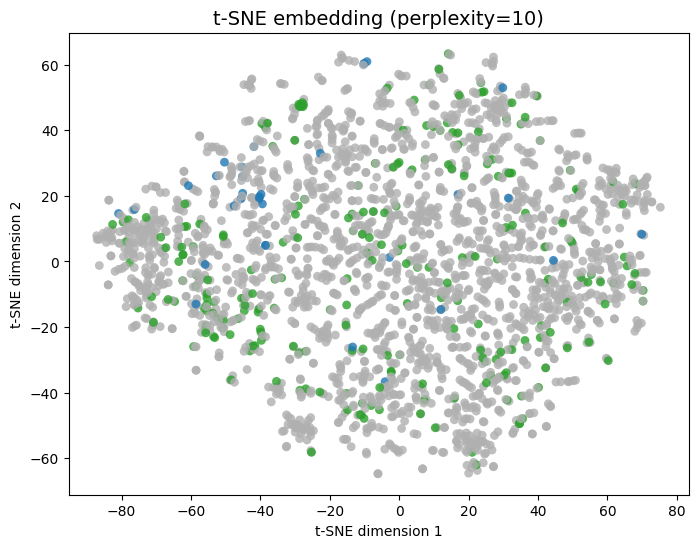

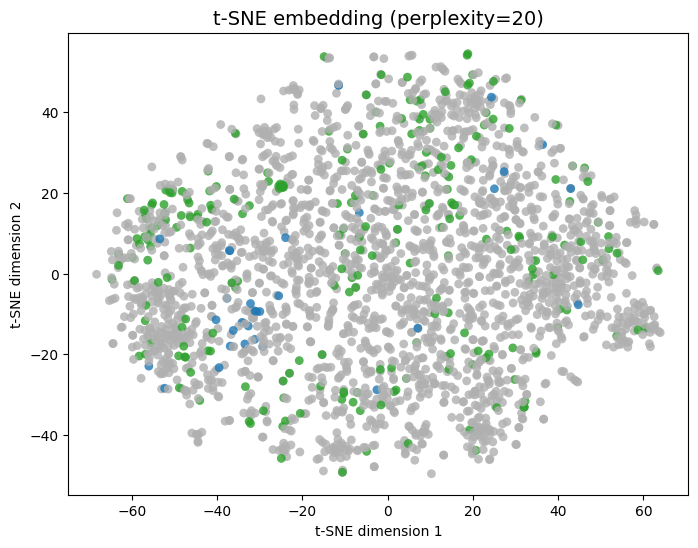

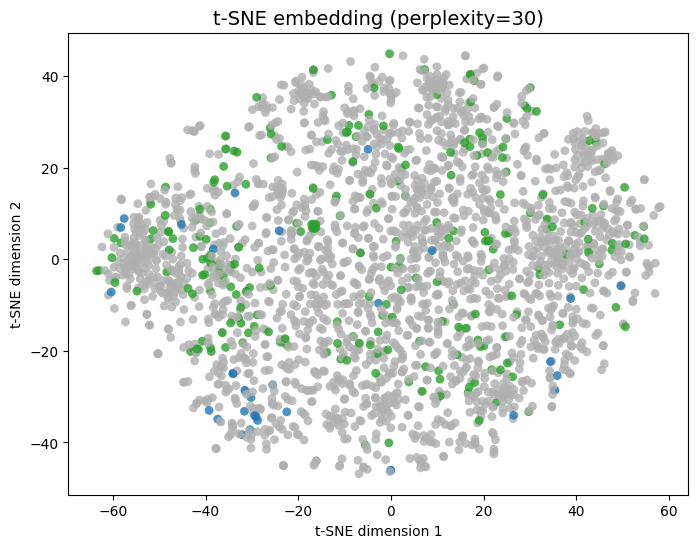

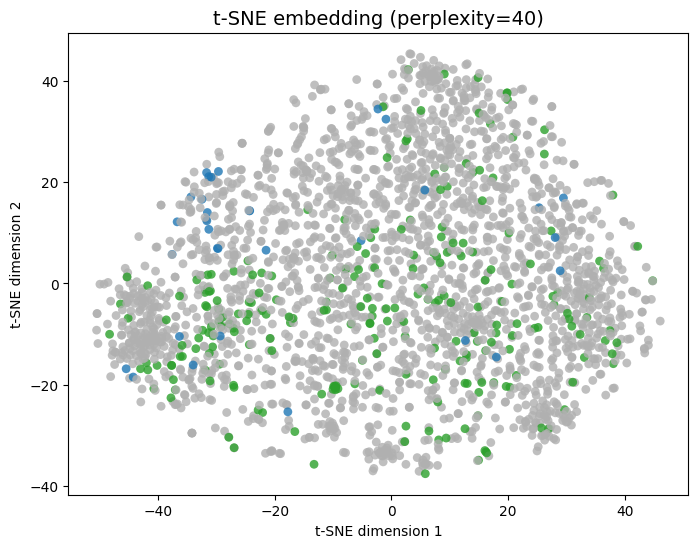

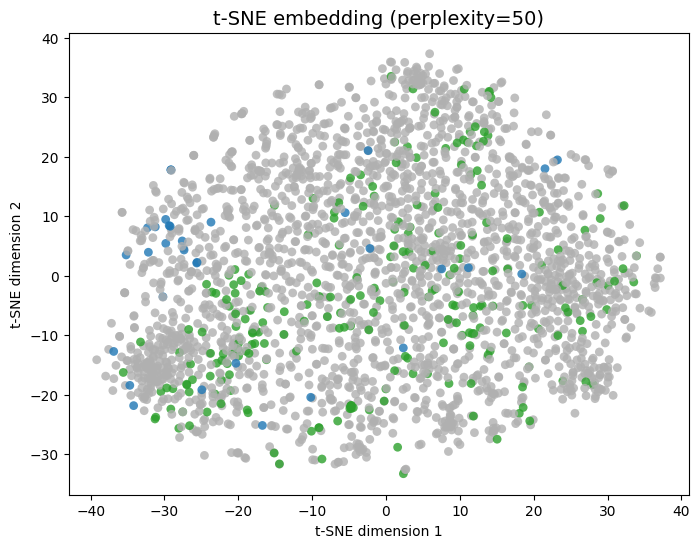

In [14]:
color_palette = {
    0: '#1f77b4', 
    1: '#ff7f0e',  
    2: '#2ca02c',  
    3: '#B0B0B0'   
}

for p in perps:
    coords = tsne_results[p]
    colors = [color_palette[c] for c in color_codes]
    
    plt.figure(figsize=(8,6))  # large plot
    plt.scatter(coords[:, 0], coords[:, 1], 
                c=colors, s=40, alpha=0.8, edgecolor='none')
    plt.title(f't-SNE embedding (perplexity={p})', fontsize=14)
    plt.xlabel("t-SNE dimension 1")
    plt.ylabel("t-SNE dimension 2")
    plt.show()


#### Choosing final perplexity

Explain your final choice (justify using the visualizations above). Write your justification here.

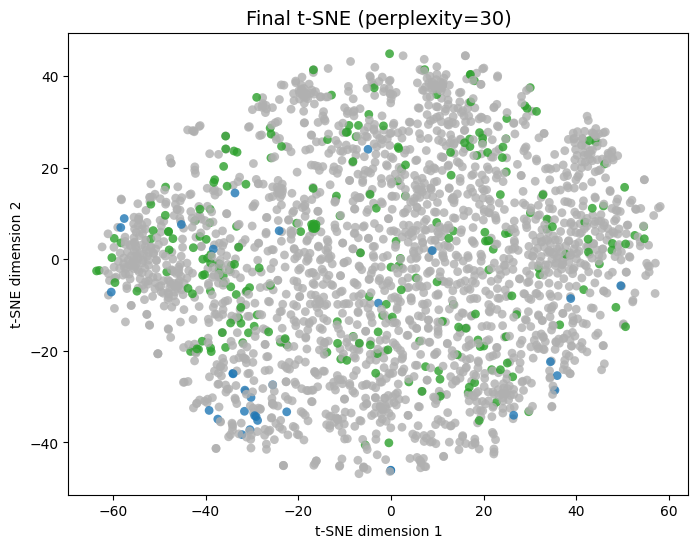

In [15]:
colors = [color_palette.get(c, '#B0B0B0') for c in color_codes]

final_p = 30
tsne_final = TSNE(n_components=2, perplexity=final_p, random_state=42, init='pca', learning_rate='auto')
tsne_2d = tsne_final.fit_transform(X_scaled)

plt.figure(figsize=(8, 6))
plt.scatter(tsne_2d[:, 0], tsne_2d[:, 1], 
            c=colors,         
            s=40,              
            alpha=0.8,
            edgecolor='none')  

plt.title(f'Final t-SNE (perplexity={final_p})', fontsize=14)
plt.xlabel("t-SNE dimension 1")
plt.ylabel("t-SNE dimension 2")

plt.show()

### Veracity inspection


#### Outliers

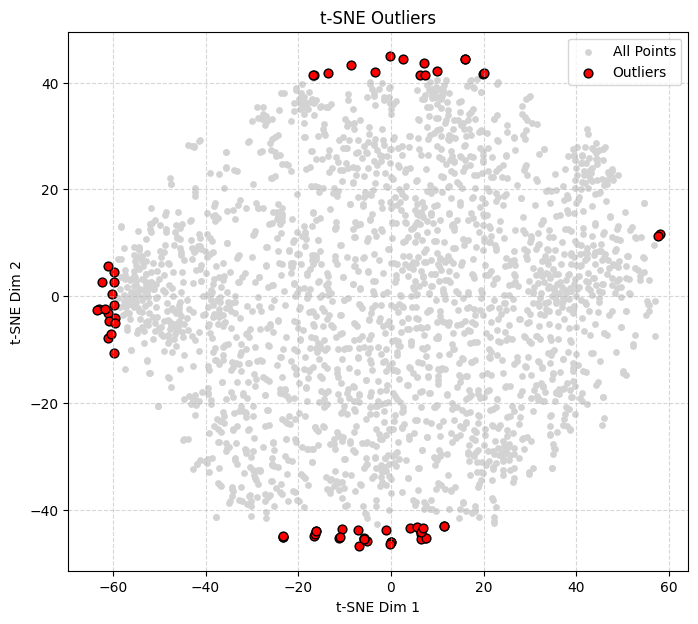

Number of outliers detected: 64


In [16]:
from scipy.stats import zscore

z_dim1 = zscore(tsne_2d[:,0])
z_dim2 = zscore(tsne_2d[:,1])
outlier_mask = (np.abs(z_dim1) > 2) | (np.abs(z_dim2) > 2)  # slightly stricter

plt.figure(figsize=(8,7))
plt.scatter(tsne_2d[:,0], tsne_2d[:,1], c='lightgray', s=15, label='All Points')
plt.scatter(tsne_2d[outlier_mask,0], tsne_2d[outlier_mask,1], 
            c='red', s=40, edgecolor='black', label='Outliers')
plt.title('t-SNE Outliers')
plt.xlabel('t-SNE Dim 1')
plt.ylabel('t-SNE Dim 2')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

print("Number of outliers detected:", outlier_mask.sum())


#### Noisy/Ambiguous Labels

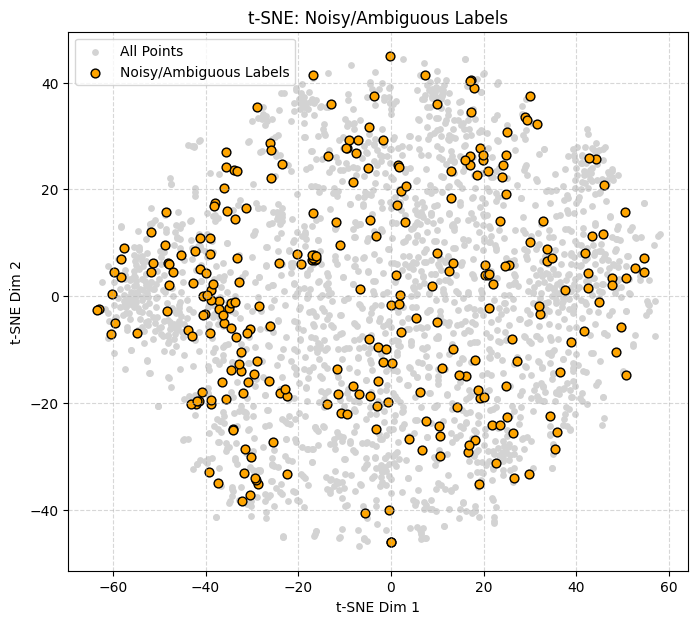

Number of potentially noisy labels: 269


In [17]:
from sklearn.neighbors import NearestNeighbors

nbrs = NearestNeighbors(n_neighbors=21).fit(tsne_2d)
_, indices = nbrs.kneighbors(tsne_2d)

neighbor_majority = []
for i in range(tsne_2d.shape[0]):
    neigh = color_codes[indices[i,1:]]  
    maj = np.bincount(neigh).argmax()
    neighbor_majority.append(maj)

neighbor_majority = np.array(neighbor_majority)
noisy_mask = (neighbor_majority != color_codes)

plt.figure(figsize=(8,7))
plt.scatter(tsne_2d[:,0], tsne_2d[:,1], c='lightgray', s=15, label='All Points')
plt.scatter(tsne_2d[noisy_mask,0], tsne_2d[noisy_mask,1], 
            c='orange', s=40, edgecolor='black', label='Noisy/Ambiguous Labels')
plt.title('t-SNE: Noisy/Ambiguous Labels')
plt.xlabel('t-SNE Dim 1')
plt.ylabel('t-SNE Dim 2')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

print("Number of potentially noisy labels:", noisy_mask.sum())


**Hypothesis on what these unusual expression patterns might represent**

These outliers could represent several possibilities: 
1) experimental errors or contamination
2) genuinely rare biological states or responses to a specific condition not captured by the main functional labels
3) data points that were fundamentally misclassified at the source

#### Hard-to-Learn Samples

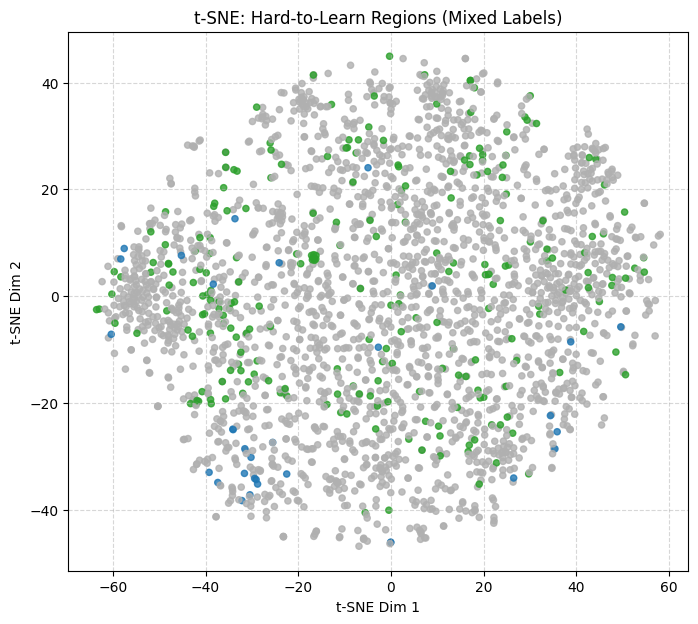

In [18]:
plt.figure(figsize=(8,7))
plt.scatter(tsne_2d[:,0], tsne_2d[:,1], c=colors, s=20, alpha=0.8)
plt.title('t-SNE: Hard-to-Learn Regions (Mixed Labels)')
plt.xlabel('t-SNE Dim 1')
plt.ylabel('t-SNE Dim 2')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()


**A simple classifier would likely struggle in these regions**

These mixed regions are difficult for simple classifiers because the classes are not linearly separable. A simple model, like logistic regression, tries to separate classes by drawing a straight line. In these mixed zones, no straight line can effectively separate the different colored points, leading to high misclassification error.

## Part C — Isomap and Manifold Learning

**Isomap and t-SNE**

Isomap is designed to understand the big picture by preserving the global structure of your data. It calculates the true distances between points not in a straight line, but by measuring the path along the data's underlying curved surface. The main goal of Isomap is to create a plot that faithfully represents the overall shape and the large-scale relationships between all points, giving you a map that respects the intrinsic geometry of the entire dataset.

In contrast, t-SNE focuses intensely on preserving the local structure. Its primary mission is to ensure that points that are immediate neighbors in the original, high-dimensional data remain immediate neighbors on the final plot. It excels at creating tight, visually clean clusters by focusing only on these close relationships. This intense local focus, however, means that the distances and positions between these clusters are often distorted and don't reflect the true global layout. Therefore, t-SNE is superior for seeing how data groups together locally, while Isomap provides a better sense of the overall landscape.

### Isomap Implementation

In [19]:
isomap = Isomap(n_components=2, n_neighbors=10)
iso_2d = isomap.fit_transform(X_scaled)
print('Isomap embedding shape:', iso_2d.shape)

Isomap embedding shape: (2417, 2)


### Visualization

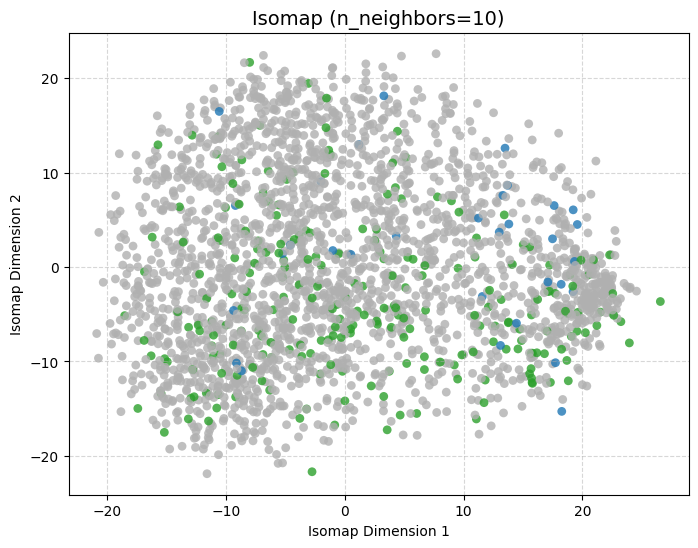

In [20]:
colors = [color_palette.get(c, '#B0B0B0') for c in color_codes]

plt.figure(figsize=(8, 6)) 
plt.scatter(iso_2d[:, 0], iso_2d[:, 1], 
            c=colors,           
            s=40,               
            alpha=0.8,
            edgecolor='none')

plt.title('Isomap (n_neighbors=10)', fontsize=14)
plt.xlabel("Isomap Dimension 1")
plt.ylabel("Isomap Dimension 2")
plt.grid(True, linestyle='--', alpha=0.5)

plt.show()

### Comparison & Curvature


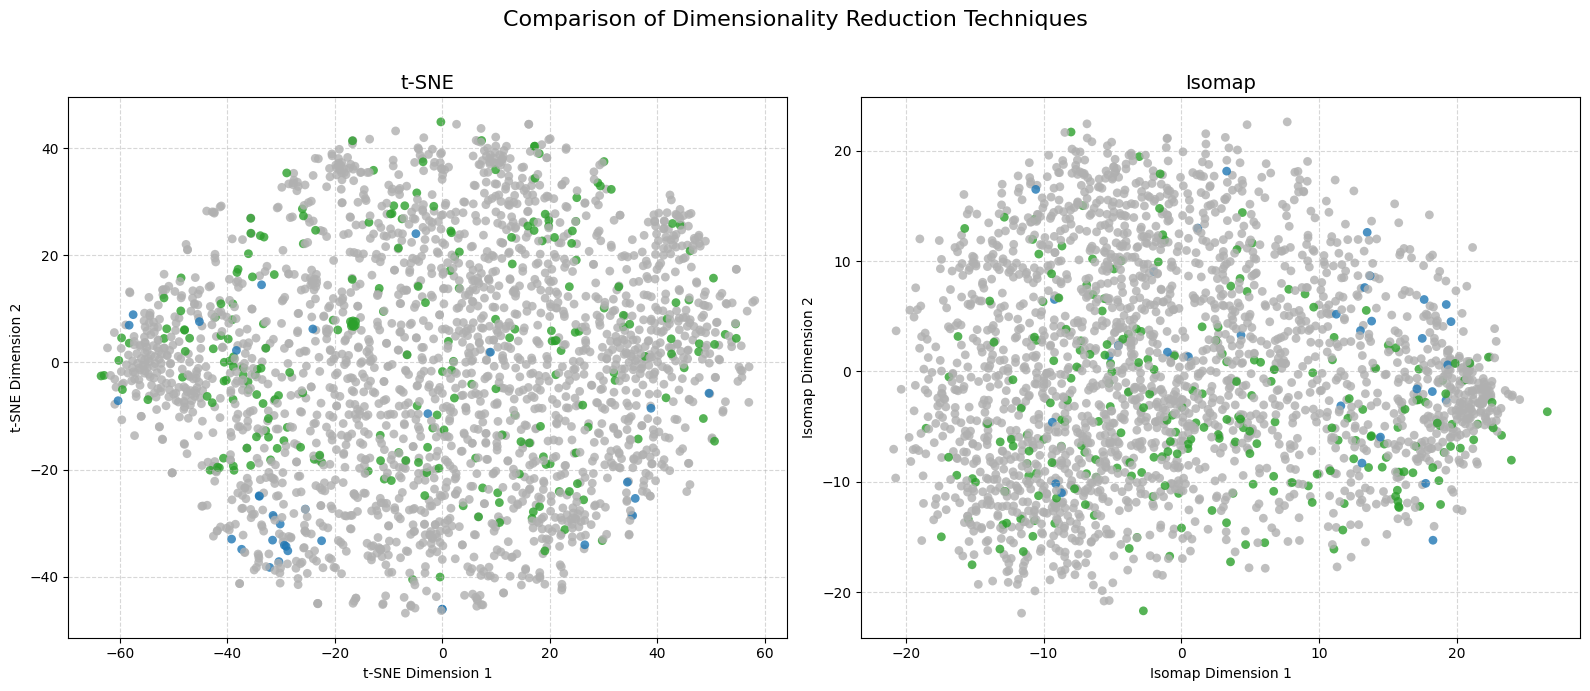

In [21]:
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

axes[0].scatter(tsne_2d[:, 0], tsne_2d[:, 1], 
                c=colors, 
                s=40, 
                alpha=0.8,
                edgecolor='none')
axes[0].set_title('t-SNE', fontsize=14)
axes[0].set_xlabel("t-SNE Dimension 1")
axes[0].set_ylabel("t-SNE Dimension 2")
axes[0].grid(True, linestyle='--', alpha=0.5)


axes[1].scatter(iso_2d[:, 0], iso_2d[:, 1], 
                c=colors, 
                s=40, 
                alpha=0.8,
                edgecolor='none')
axes[1].set_title('Isomap', fontsize=14)
axes[1].set_xlabel("Isomap Dimension 1")
axes[1].set_ylabel("Isomap Dimension 2")
axes[1].grid(True, linestyle='--', alpha=0.5)


fig.suptitle('Comparison of Dimensionality Reduction Techniques', fontsize=16)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


The Isomap and t-SNE visualizations provide two very different but complementary views of the data. The t-SNE plot excels at showing local structure, separating the data into tight, distinct, and visually pleasing clusters. It's designed to show which points are immediate neighbors. However, the distances and a-rrangement between these clusters in the t-SNE plot are not reliable.

In contrast, Isomap is far better at revealing the global structure of the gene expression data. While t-SNE breaks the data into separate "islands," the Isomap plot typically reveals a more continuous, stretched-out shape (often like a "V" or "U"). This suggests that the distinct clusters identified by t-SNE are not actually isolated in the high-dimensional space but are connected along a continuous underlying structure. Isomap, by preserving these long-range distances, gives a more faithful representation of the dataset's overall landscape.

**The Data Manifold and Classification Difficulty**

The concept of a data manifold refers to the idea that high-dimensional data often lies on a lower-dimensional, curved surface.  Think of a rolled-up sheet of paper: the points on the paper exist in 3D space, but their intrinsic geometry is 2D. The Isomap algorithm is designed specifically to "unroll" this surface to see its true shape.

The Isomap plot strongly suggests that the gene expression data lies on a highly curved or complex manifold. If the data structure were simple and linear, the plot would look more like a simple, spherical cloud. The stretched and bent "V" shape indicates that the relationships between gene profiles are non-linear and follow a complex geometric path.

This complexity directly relates to the difficulty of classification.

- A simple, linear classifier (like Logistic Regression) works by finding a straight line or a flat plane to separate the classes.

- On a highly curved manifold, no single straight line can effectively separate the classes. A linear boundary would cut right through the curved clusters, leading to many misclassifications.

- Therefore, the complexity of the manifold revealed by Isomap shows that more sophisticated, non-linear models would be required to learn a curved decision boundary that can accurately follow the shape of the data.